# Final Project

## Author: Cho Laam Yuen

## (1) describe in detail the substantive problem you are interested in working on for this assignment

For this project I was looking for a image classification problem that could be tied to something that I interacted with or used on a daily basis. One particular problem I am interested in is how tags are generated when videos or images are uploaded onto a digital platform. For example, I found that I could filter for different images of objects or people on the iPhone. Such that if I typed 'cat' into the search bar, I would get a selection of all the identified images of my cat from my photo album. This problem is related to object detection, but I believe that it is more broadly related to the similar problem of image classification. I perceive object detection to be a more straightforward problem, where there is more or less no overlap between categories. As such, I am more interested in whether neural networks can identify different themes from images that have objects that could belong to more than 1 category. 

For this project I am working to identify the content category (e.g. News, Food, Science, etc.) of YouTube thumbnails. This is an interesting problem because there is both a diversity of thumbnails within categories as well as similarity of thumbnails between categories. More concretely, a thumbnail from a News channel could be of a news anchor seated professionally at a table or an image of an explosion from some newsworthy incident. From a object detection point of view the 2 images are completely unrelated as one depicts a person and the other depicts a scene. However, from a classification point of view, a neural network may be able to identify some similarity in the image beyond the content. An example of similarity is an image of a person laughing which could be from a Comedy channel but could also belong to a Gaming channel. As an object detection problem these images would be classified as the same thing (i.e. a person), however, from a classification perspective maybe there is something about the colors or positioning that could diffrentiate the 2 images. For these reasons, I believe that there is a lot of complexity in classifying these images into their respecctive categories. 


## (2) describe your data (including the features, target, and the general type of data you are working with)

I am working with image data downloaded from [Kaggle](https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset) that has been classified into 10 categories. 

* Automobile
* Blog
* Comedy
* **Entertainment**
* Food
* **Informative**
* News
* Science
* **Tech**
* Video Games

However, since the dataset is quite small with only 2303 images and the number of images within each category is quite uneven (min: 160; max: 300). I have decided to combine some categories together to create 3 large categories instead to better train my model for this problem. The resulting 3 categories are **Entertainment**, **Informative**, and **Tech**. The **Entertainment** category encompasses Blog, Comedy, Entertainment, and Food. The **Informative** category includes News, Science, and Informative. Finally, the **Tech** category combines Automobile, Tech, and Video Games. 





## (3) describe why you think Deep Learning systems would be a good methodological choice, and the specific architecture(s) you think appropriate to explore

I think that deep learning systems, in particular, convolutional neural networks (CNNs) would be appropriate to explore my chosen problem because image data is quite complex 

## Load Data and Packages

In [4]:
#connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#change working directory
%cd /content/drive/My\ Drive/Adv\ ML/gr5074-final-project-ChoLaamY/
!pwd

/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY
/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY


In [2]:
#load my libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [3]:
#code taken from example code for Covid_Image_Classification (HW2)
#extracting all filenames iteratively
base_path = 'thumbnails3'
categories = ['Entertainment', 'Informative', 'Tech',]

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [813, 716, 774]


## Preprocess Data and Setup

In [25]:
#writing the preprocessor
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(224, 224)): 
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X


In [26]:
#check whether the preprocessor worked
#(Height, Width, Channels)
preprocessor('thumbnails3/Tech/_O_kWL-YhZE.jpg').shape

(224, 224, 3)

In [27]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [28]:
#check length of files matched number of images in my dataset
len(image_filepaths)
print(len(X) ) #same number of images in dataset
print(X.shape ) #dimensions should be 180, 320, 3 for all images
print(X.min() ) #min value of every image is 0
print(X.max() ) #max value of every image is 1


2303
(2303, 224, 224, 3)
0.0
1.0


In [29]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# 3 folders with the corresponding number of images in each folder

print('number of images for each category:', [len(f) for f in fnames])
Entertainment=list(repeat('Entertainment', 813))
Informative=list(repeat('Informative', 716))
Tech=list(repeat('Tech', 774))


#combine into single list of y labels
y_labels = Entertainment+Informative+Tech

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [813, 716, 774]
2303


,Entertainment,Informative,Tech
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
2298,0,0,1
2299,0,0,1
2300,0,0,1
2301,0,0,1


In [30]:
#train test split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 874920)

#check y_test set
y_test.sum()

Entertainment    163
Informative      143
Tech             155
dtype: int64

## Visualizing the Thumbnails

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

pic1 = preprocessor('thumbnails3/Entertainment/_qIRtFE6aIc.jpg')
pic2 = preprocessor('thumbnails3/Entertainment/8GxqvnQyaxs.jpg')
pic3 = preprocessor('thumbnails3/Entertainment/n4bucphC9r4.jpg')
pic4 = preprocessor('thumbnails3/Informative/UCA1A5GqCdQ.jpg')
pic5 = preprocessor('thumbnails3/Informative/el6No1wNKf0.jpg')
pic6 = preprocessor('thumbnails3/Informative/tJevBNQsKtU.jpg')
pic7 = preprocessor('thumbnails3/Tech/3dEfc9LL9bQ.jpg')
pic8 = preprocessor('thumbnails3/Tech/bCu0Z71QRF0.jpg')
pic9 = preprocessor('thumbnails3/Tech/DTBu4tigSDo.jpg')

#make a grid for the images
figure = plt.figure(figsize=(10, 10))
grid = ImageGrid(figure, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.5,
                 )

for ax, pic in zip(grid, [pic1, pic2, pic3, pic4, pic5, pic6, pic7, pic8, pic9]):
  ax.imshow(pic)
  
#adjust the text size  
  plt.rc('font', size=10)

#create labels for images
  figure.text(0.13, 0.89, 'Entertainment', color="black")
  figure.text(0.39, 0.89, 'Entertainment', color="black")
  figure.text(0.66, 0.89, 'Entertainment', color="black")
  figure.text(0.13, 0.62, 'Informative', color="black")
  figure.text(0.39, 0.62, 'Informative', color='black')
  figure.text(0.66, 0.62, 'Informative', color='black')
  figure.text(0.13, 0.36, 'Tech', color='black')
  figure.text(0.39, 0.36, 'Tech', color='black')
  figure.text(0.66, 0.36, 'Tech', color='black')

## Model Experimentation

## (4) show the code and outputs of 3-5 different experiments with variants of your proposed architecture(s)

#### Model 1

In [ ]:
with tf.device('/device:GPU:0'):

  model1 = Sequential()
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(180, 320, 3)))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))

  model1.add(Dropout(0.1))
  model1.add(Flatten())
  model1.add(Dense(16, activation='relu')) # One fully-connected layer
  model1.add(Dropout(0.1))

  model1.add(Dense(3, activation='softmax'))

  model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.fit(X_train, y_train, 
                    epochs = 5, verbose=1, validation_data=(X_test,y_test))

Epoch 1/5
58/58 [==============================] - 126s 2s/step - loss: 1.0949 - accuracy: 0.3730 - val_loss: 1.0876 - val_accuracy: 0.4403
Epoch 2/5
58/58 [==============================] - 125s 2s/step - loss: 1.0637 - accuracy: 0.4490 - val_loss: 1.0554 - val_accuracy: 0.4338
Epoch 3/5
58/58 [==============================] - 130s 2s/step - loss: 1.0244 - accuracy: 0.4810 - val_loss: 1.0661 - val_accuracy: 0.4642
Epoch 4/5
58/58 [==============================] - 132s 2s/step - loss: 0.9927 - accuracy: 0.5098 - val_loss: 0.9398 - val_accuracy: 0.5835
Epoch 5/5
58/58 [==============================] - 130s 2s/step - loss: 0.9463 - accuracy: 0.5353 - val_loss: 1.0015 - val_accuracy: 0.5315


## Image Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#create augmentation function for training set
train_imagegen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    validation_split=0.2) #set validation split

#create (no) augmentation function for test set
val_imagegen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [11]:
#augmentation on training set
train_data = train_imagegen.flow_from_directory(directory='thumbnails3',
                                                batch_size=128,
                                                shuffle=True,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                subset = 'training')


Found 1844 images belonging to 3 classes.


In [12]:
#augmentation on test set
val_data = val_imagegen.flow_from_directory(directory='thumbnails3',
                                                batch_size=128,
                                                shuffle=False,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                subset = 'validation')

Found 459 images belonging to 3 classes.


In [13]:
#code to plot images in a 1 x 5 grid from week 10 lecture notebook
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

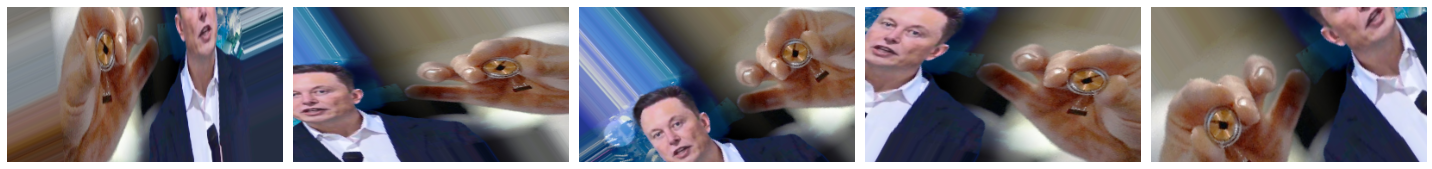

In [14]:
#plot the augmented images to check
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Model 2

In [48]:
with tf.device('/device:GPU:0'):

  model2 = Sequential()
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(180, 320, 3)))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))

  model2.add(Dropout(0.1))
  model2.add(Flatten())
  model2.add(Dense(16, activation='relu')) # One fully-connected layer
  model2.add(Dropout(0.1))

  model2.add(Dense(3, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model2.fit(train_data, 
           epochs = 10, verbose=1, validation_data=val_data)

Epoch 1/5
15/15 [==============================] - 626s 41s/step - loss: 1.0040 - accuracy: 0.5005 - val_loss: 0.9718 - val_accuracy: 0.5294
Epoch 2/5
15/15 [==============================] - 167s 11s/step - loss: 1.0049 - accuracy: 0.5065 - val_loss: 0.9154 - val_accuracy: 0.5904
Epoch 3/5
15/15 [==============================] - 158s 10s/step - loss: 0.9824 - accuracy: 0.5277 - val_loss: 0.9490 - val_accuracy: 0.5425
Epoch 4/5
15/15 [==============================] - 157s 10s/step - loss: 0.9893 - accuracy: 0.5060 - val_loss: 0.9397 - val_accuracy: 0.5534
Epoch 5/5
15/15 [==============================] - 178s 12s/step - loss: 0.9730 - accuracy: 0.5390 - val_loss: 0.9104 - val_accuracy: 0.5817


#### Model 3 (ResNet)

In [17]:
from tensorflow.keras.applications import ResNet50
with tf.device('/device:GPU:0'):
  
  base_model_res = ResNet50(input_shape=(180, 320, 3), 
                          include_top=False, 
                          weights='imagenet')
  
#freeze the weights
  base_model_res.trainable = False

#flatten, add 3 dense layers, and 2 droupout
flat = Flatten()(base_model_res.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.2)(layer1)
layer2 = Dense(16, activation = 'relu')(drop)
drop2 = Dropout(0.1)(layer2)
output = Dense(3, activation='softmax')(drop2)

model3 = Model(inputs=base_model_res.inputs, outputs=output)

#compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.fit(train_data, epochs=7, verbose=1, validation_data=val_data)


Epoch 1/7
15/15 [==============================] - 362s 24s/step - loss: 1.2991 - accuracy: 0.3351 - val_loss: 1.0984 - val_accuracy: 0.3355
Epoch 2/7
15/15 [==============================] - 346s 23s/step - loss: 1.0983 - accuracy: 0.3362 - val_loss: 1.0982 - val_accuracy: 0.3355
Epoch 3/7
15/15 [==============================] - 333s 22s/step - loss: 1.0981 - accuracy: 0.3362 - val_loss: 1.0981 - val_accuracy: 0.3355
Epoch 4/7
15/15 [==============================] - 337s 22s/step - loss: 1.0981 - accuracy: 0.3346 - val_loss: 1.0979 - val_accuracy: 0.3355
Epoch 5/7
15/15 [==============================] - 337s 22s/step - loss: 1.0979 - accuracy: 0.3254 - val_loss: 1.0978 - val_accuracy: 0.3529
Epoch 6/7
15/15 [==============================] - 356s 24s/step - loss: 1.0978 - accuracy: 0.3471 - val_loss: 1.0977 - val_accuracy: 0.3529
Epoch 7/7
15/15 [==============================] - 350s 23s/step - loss: 1.0976 - accuracy: 0.3530 - val_loss: 1.0977 - val_accuracy: 0.3529


#### Model 4 (VGG16)

In [18]:
from tensorflow.python.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'):

  base_model = VGG16(input_shape=(180, 320, 3),
                   include_top=False,
                   weights='imagenet')
#freeze weights
base_model.trainable=False

#flatten, add dense layer, dropout, and another dense layer 
flat = Flatten()(base_model.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model4 = Model(inputs=base_model.inputs, outputs=output)

#compile model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.fit(train_data, epochs=7, verbose=1, validation_data=val_data)


Epoch 1/7
15/15 [==============================] - 1031s 69s/step - loss: 1.5717 - accuracy: 0.3698 - val_loss: 1.0909 - val_accuracy: 0.4096
Epoch 2/7
15/15 [==============================] - 1083s 73s/step - loss: 1.0806 - accuracy: 0.4268 - val_loss: 1.0699 - val_accuracy: 0.4597
Epoch 3/7
15/15 [==============================] - 1023s 69s/step - loss: 1.0687 - accuracy: 0.4268 - val_loss: 1.0587 - val_accuracy: 0.4793
Epoch 4/7
15/15 [==============================] - 1026s 69s/step - loss: 1.0663 - accuracy: 0.4300 - val_loss: 1.0641 - val_accuracy: 0.4597
Epoch 5/7
15/15 [==============================] - 1079s 73s/step - loss: 1.0686 - accuracy: 0.4138 - val_loss: 1.0591 - val_accuracy: 0.4793
Epoch 6/7
15/15 [==============================] - 1022s 69s/step - loss: 1.0603 - accuracy: 0.4246 - val_loss: 1.0778 - val_accuracy: 0.4074
Epoch 7/7
15/15 [==============================] - 1024s 69s/step - loss: 1.0548 - accuracy: 0.4371 - val_loss: 1.0598 - val_accuracy: 0.4444


#### (VGG16) without image augmentation

In [31]:
from tensorflow.python.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'):

  base_model_VGG = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')
#freeze weights
base_model_VGG.trainable=False

#flatten, add dense layer, dropout, and another dense layer 
flat = Flatten()(base_model_VGG.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model5 = Model(inputs=base_model_VGG.inputs, outputs=output)

#compile model
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model5.fit(X_train, y_train, 
           epochs=7, verbose=1, validation_data=(X_test, y_test))

Epoch 1/7
58/58 [==============================] - 864s 15s/step - loss: 0.9661 - accuracy: 0.5347 - val_loss: 0.8685 - val_accuracy: 0.6161
Epoch 2/7
58/58 [==============================] - 866s 15s/step - loss: 0.6741 - accuracy: 0.7020 - val_loss: 0.7061 - val_accuracy: 0.6941
Epoch 3/7
58/58 [==============================] - 868s 15s/step - loss: 0.4853 - accuracy: 0.8024 - val_loss: 0.7002 - val_accuracy: 0.6898
Epoch 4/7
58/58 [==============================] - 868s 15s/step - loss: 0.3479 - accuracy: 0.8702 - val_loss: 0.7020 - val_accuracy: 0.7115
Epoch 5/7
58/58 [==============================] - 871s 15s/step - loss: 0.2577 - accuracy: 0.9142 - val_loss: 0.7134 - val_accuracy: 0.7072
Epoch 6/7
58/58 [==============================] - 871s 15s/step - loss: 0.1961 - accuracy: 0.9392 - val_loss: 0.7853 - val_accuracy: 0.7180
Epoch 7/7
58/58 [==============================] - 868s 15s/step - loss: 0.1616 - accuracy: 0.9468 - val_loss: 0.7966 - val_accuracy: 0.7072


## (5) select the model that best fits the problem you are trying to solve and discuss why it fulfills this purpose